# Tabular models

In [0]:
from fastai.tabular import *

In [0]:
# fix directory to gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(root_dir +'/data/titanic')
path.ls()

[PosixPath('/content/gdrive/My Drive/data/titanic/gender_submission.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/train.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/models'),
 PosixPath('/content/gdrive/My Drive/data/titanic/test1.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/trial.gsheet'),
 PosixPath('/content/gdrive/My Drive/data/titanic/trial.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/trainFeatured.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/testFeatured.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/StackingSubmission.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/submission.csv')]

Tabular data should be in a Pandas `DataFrame`.

## Differentiate data  and store according data accordingly 

In [0]:
# path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'trainFeatured.csv')
df.head()

,Unnamed: 0,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,1,0,2,0,3,1,51,1,2,0,3
2,2,1,3,0,1,0,1,0,22,0,1,1,2
3,3,1,1,0,2,0,3,0,44,1,2,0,3
4,4,0,3,1,2,0,1,0,24,0,1,1,1


In [0]:
len(df)

891

In [0]:
#differentiate dependent, categorical and continuous variable
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex','Embarked','Age','Fare','Has_Cabin','IsAlone','Title']
cont_names = [ 'FamilySize', 'Parch','Name_length']
procs = [FillMissing, Categorify, Normalize]

#assign validation set
valid_idx = range(len(df)-200, len(df))

In [0]:
# assign test set
test = TabularList.from_df(df.iloc[600:800].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [0]:
# assign validation set, test set
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct=0.2)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
# visualize the cont & cat var
data.show_batch(rows=10)

Pclass,Sex,Embarked,Age,Fare,Has_Cabin,IsAlone,Title,FamilySize,Parch,Name_length,target
3,0,1,0,2,0,0,2,0.0519,-0.4686,-0.7526,0
2,0,0,1,2,0,0,3,1.2648,0.7376,2.5558,1
3,1,0,1,0,0,1,1,-0.5546,-0.4686,-0.5391,0
3,1,0,1,1,0,0,1,0.6584,-0.4686,0.1012,0
3,1,0,2,0,0,1,1,-0.5546,-0.4686,0.1012,0
1,0,0,1,3,1,0,3,1.2648,1.9438,2.1289,0
3,0,0,1,3,0,0,2,1.8713,1.9438,0.9549,0
3,0,0,1,2,0,0,3,0.0519,-0.4686,1.9154,0
2,1,0,1,2,0,1,1,-0.5546,-0.4686,-0.0055,0
2,0,0,1,1,0,0,2,0.6584,1.9438,0.2079,1


## assign learning model and perform training

In [0]:
# assign parameters for learning model
learn = tabular_learner(data, layers=[1000,500], metrics=accuracy,ps=[0.001,0.01], emb_drop=0.04)

In [0]:
??tabular_learner

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


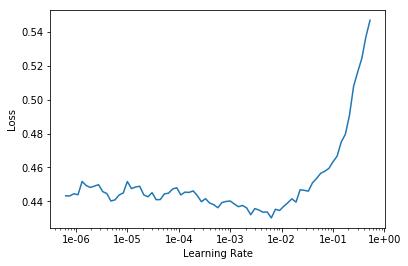

In [0]:
learn.recorder.plot()

In [0]:
# learn.fit(10, 4e-4/4)

In [0]:
learn.fit_one_cycle(10, 3e-5/4, wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.431209,0.410931,0.859551,00:00
1,0.428548,0.410071,0.859551,00:00
2,0.432198,0.410532,0.865169,00:00
3,0.431338,0.411138,0.859551,00:00
4,0.426716,0.410370,0.853933,00:00
5,0.429612,0.409528,0.853933,00:00
6,0.431217,0.408820,0.842697,00:00
7,0.429642,0.408164,0.859551,00:00
8,0.429782,0.408076,0.853933,00:00
9,0.429538,0.407861,0.859551,00:00


In [0]:
learn.save('stage1-layer300-100')

In [0]:
learn = tabular_learner(data, layers=[1000,100], metrics=accuracy)

In [0]:
learn.fit(10, 7e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.387414,0.405694,0.825000,00:00
1,0.379296,0.402185,0.830000,00:00
2,0.373430,0.409113,0.815000,00:00
3,0.373889,0.403043,0.810000,00:00
4,0.368130,0.418230,0.810000,00:00
5,0.366903,0.435384,0.805000,00:00
6,0.368701,0.413152,0.805000,00:00
7,0.369103,0.435938,0.805000,00:00
8,0.365253,0.428860,0.810000,00:00
9,0.358512,0.431249,0.805000,00:00


In [0]:
learn.fit_one_cycle(10, slice(1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.321473,0.433600,0.790000,00:00
1,0.311038,0.431844,0.790000,00:00
2,0.313715,0.434415,0.780000,00:00
3,0.320234,0.432745,0.785000,00:00
4,0.323885,0.431974,0.790000,00:00
5,0.328596,0.430535,0.790000,00:00
6,0.326484,0.430090,0.790000,00:00
7,0.326693,0.432940,0.790000,00:00
8,0.325122,0.432123,0.790000,00:00
9,0.322734,0.431763,0.790000,00:00


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


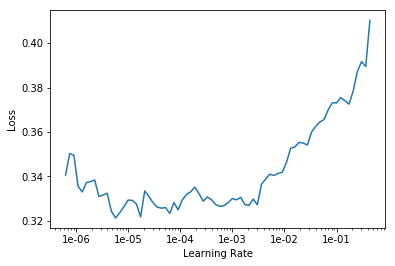

In [0]:
learn.recorder.plot()

## Inference

In [0]:
dfTest= pd.read_csv(path/'testFeatured.csv')
dfTest.head()

,Unnamed: 0,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,2,16,0,1,1,1
1,1,3,0,2,0,0,0,32,0,2,0,3
2,2,2,1,3,0,1,2,25,0,1,1,1
3,3,3,1,1,0,1,0,16,0,1,1,1
4,4,3,0,1,1,1,0,44,0,3,0,3


In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/data/titanic/gender_submission.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/train.csv'),
 PosixPath('/content/gdrive/My Drive/data/titanic/models'),
 PosixPath('/content/gdrive/My Drive/data/titanic/test.gsheet'),
 PosixPath('/content/gdrive/My Drive/data/titanic/test.csv')]

In [0]:
# row = dfTest.iloc[0]

In [0]:
# learn.predict??

In [0]:
import csv


with open(path/'submission.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    for i in range(dfTest.shape[0]):
      row = dfTest.iloc[i]
      if i == 0 :
        csvData = ['PassengerId','Survived']
        writer.writerow(csvData)
        csvData = [row[0],learn.predict(dfTest.iloc[i])[1].item()]
      else:
        csvData = [row[0],learn.predict(dfTest.iloc[i])[1].item()]
      writer.writerow(csvData)

csvFile.close()